### This is a general notebook that can treat any Metric Results

(if the test accuracies are stored in contest format)

#### Run as:

<pre>
papermill AnalyzeResults.ipynb  AnalyzeResults.W_distance.ipynb -p METRIC W_distance
</pre>

#### METRIC choices:

<pre>
W_distance
ww_D
sharpness
ww_svd10
ww_svd20
</pre>



#### Note

- Computes: Metrix correlation with Test Accuracies , saves data as (say)
<pre>
W_distance_vs_accs_task1_v4_results.csv
W_distance_vs_accs_task2_v1_results.csv
</pre>

- Computes correlation with Alpha, since needed for W_distance
- some runs exceeded the runtime so we don't count these results
- W_Distance is compared on log-log scale
- All details will be retained and documented in case the reviewers need this data


In [1]:
!ls *.csv

D_vs_accs_task1_v4_results.csv          sharpness_vs_accs_task2_v1_results.csv
D_vs_accs_task2_v1_results.csv          svd10_vs_accs_task1_v4_results.csv
W_distance_vs_accs_task1_v4_results.csv svd10_vs_accs_task2_v1_results.csv
W_distance_vs_accs_task2_v1_results.csv svd20_vs_accs_task1_v4_results.csv
sharpness_vs_accs_task1_v4_results.csv  svd20_vs_accs_task2_v1_results.csv


In [2]:
import numpy as np
import pandas as pd
import json, glob, re

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
from scipy.stats import kendalltau, spearmanr

import import_ipynb
import Utils as U

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

%load_ext watermark
%watermark

importing Jupyter notebook from Utils.ipynb


2021-05-23T22:05:05-07:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


To evaluate this, lets first read in test accuracies into model groups.

Recall the model groups for each task are:

#### Task 1 and Task 2 Model groups

We see that the distance metric $\Vert\mathbf{W}-\mathbf{W}_{init}\Vert_{F}$ correlates well with the Test Accuracies  $\Delta(\theta)$, as the hyperparameters vary, for all models for both Task1 and Task2.  

And as with $\alpha$, only the Task2 6xx models, show weaker correlations.





In [3]:
METRIC = "sharpness"

In [4]:
# Parameters
METRIC = "sharpness"


In [5]:
metric_eqn = U.metric_eqn(METRIC)

RESULTS_DIR = U.RESULTS_DIR
IMG_DIR = U.IMG_DIR

metric_results_dir = "{}/ww_{}".format(RESULTS_DIR,METRIC)
if METRIC==("W_distance") or METRIC==('sharpness'):
    metric_results_dir = "{}/{}".format(RESULTS_DIR,METRIC)

print('metric = ', METRIC)
print("results dir = ",RESULTS_DIR)
!ls $RESULTS_DIR
print("out dir = ",metric_results_dir)
!ls $metric_results_dir

metric =  sharpness
results dir =  ../results
W_distance             task1_v4.predict       ww_D
sharpness              task2_v1               ww_svd10
task1_v4               task2_v1.augmented.csv ww_svd20
task1_v4.augmented.csv task2_v1.predict


out dir =  ../results/sharpness
complexity.py               task1_v4_sharpness_6xx.png
scores.html                 task1_v4_sharpness_7xx.png
scores.txt                  task2_v1.predict
task1_v4.predict            task2_v1_sharpness_10xx.png
task1_v4_sharpness_0xx.png  task2_v1_sharpness_2xx.png
task1_v4_sharpness_1xx.png  task2_v1_sharpness_6xx.png
task1_v4_sharpness_2xx.png  task2_v1_sharpness_9xx.png
task1_v4_sharpness_5xx.png


### Plots below are not saved

In [6]:
modelgroup_accuracies, _ = U.read_modelgroup_accuracies()

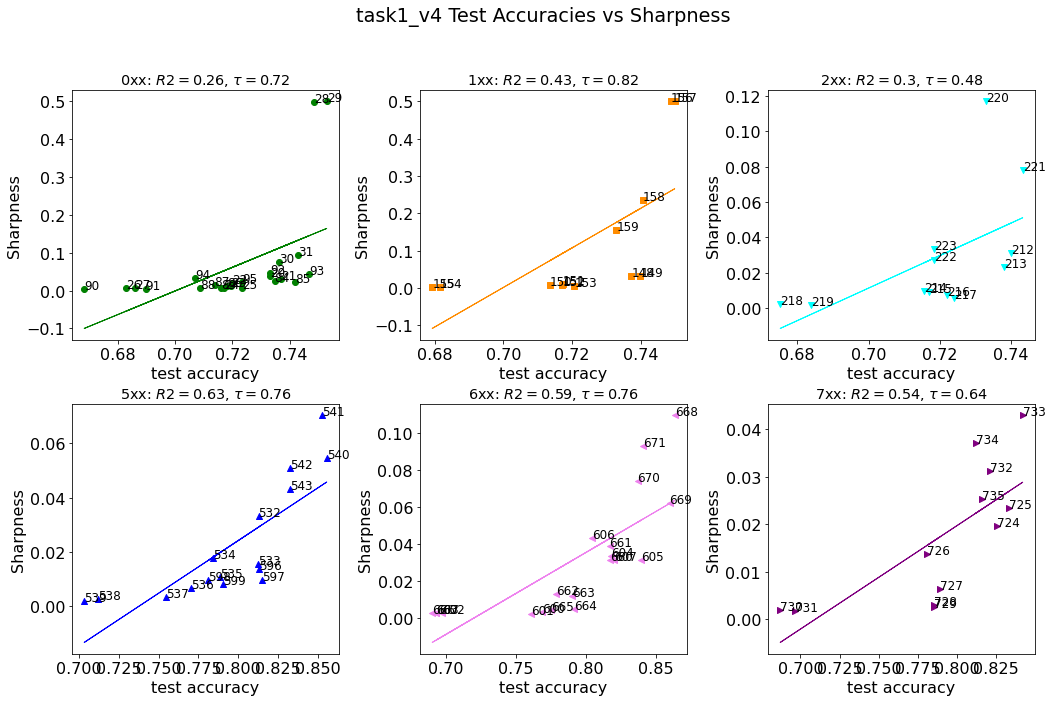

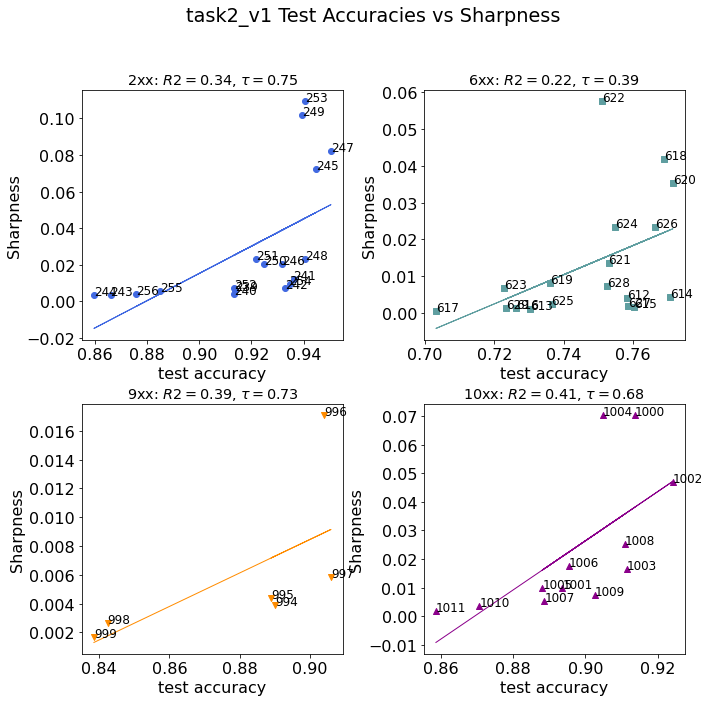

In [7]:
out_dir = metric_results_dir

ktau_s = {}
spear_s = {}

errors = {}
for task, shape in zip(["task1_v4", "task2_v1"], [(2,3), (2,2)]):
    errors[task] = {}
    task_metrics = U.read_task_metrics(task, out_dir)
    
    # plot test accuracy vs metric for each group model
    # and compute rank correlation metrics
 
    rcParams['figure.figsize'] = 5*shape[1],5*shape[0]
    rcParams.update({'font.size': 16})

    fig, axes = plt.subplots(shape[0], shape[1])
    subplts = axes.flatten()[::-1].tolist()
    fig.suptitle("{} Test Accuracies vs {}".format(task, metric_eqn))
    
    rcParams.update({'font.size': 12})
    fig.tight_layout(pad=3.0)

    
    for group_model, values in modelgroup_accuracies[task].items():
        subplt = subplts.pop()
        x, y = [], []
        
        for mid, acc in values:
            key = "{}xx".format(int(mid/100))
            errors[task][key]={}
            
            metric = task_metrics[mid]
            if metric != "EXCEEDED":

                color = U.mid_color(task,mid)
                marker = U.mid_shape(task,mid)
                subplt.scatter(acc, metric, color=color, marker=marker)
                subplt.annotate("{}".format(mid), (acc, metric))

                x.append(acc)
                y.append(metric)
            else:
                print("{} EXCEEDED".format(mid))

        if len(x)>0:

            subplt.set_xlabel("test accuracy")
            subplt.set_ylabel(metric_eqn)
            x = np.array(x).reshape(-1,1)
            y = np.array(y).reshape(-1,1)

            ktau, p_value = kendalltau(x, y)
            sp_tau,  sp_value = spearmanr(x, y)       

            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            subplt.plot(x, y_pred,  linewidth=1 ,color=color)
            
            RMSE = np.sqrt(mean_squared_error(y, y_pred))
            R2 = r2_score(y, y_pred)
            
            key = "{}xx".format(U.model_num(mid))
            errors[task][key]['R2']=R2
            errors[task][key]['spman']=sp_tau
            errors[task][key]['RMSE']=RMSE

            errors[task][key]['Ktau']=ktau
            
            subplt.set_title(key+r": $R2={:0.2}$, $\tau=${:0.2}".format(R2,ktau));
        

### Save Results for analysis later

In [8]:

for task in ["task1_v4", "task2_v1"]:
    filename = "./{}_vs_accs_{}_results.csv".format(METRIC, task)
    results_df = pd.DataFrame(errors[task]).transpose()
    results_df.index.rename('model', inplace=True)
    results_df.to_csv(filename)
    print(task)
    display(results_df)
    results_df
    
!ls *csv

task1_v4


,R2,spman,RMSE,Ktau
model,,,,
0xx,0.256569,0.855838,0.114806,0.722324
1xx,0.430305,0.931472,0.137102,0.821928
2xx,0.300853,0.671329,0.028071,0.484848
5xx,0.632944,0.884474,0.012574,0.761513
6xx,0.587851,0.917516,0.020260,0.755362
7xx,0.544590,0.825175,0.009533,0.636364


task2_v1


,R2,spman,RMSE,Ktau
model,,,,
2xx,0.338802,0.908622,0.028325,0.747545
6xx,0.219417,0.535880,0.014324,0.393445
9xx,0.386782,0.885714,0.004036,0.733333
10xx,0.414549,0.838602,0.018281,0.677003


D_vs_accs_task1_v4_results.csv          sharpness_vs_accs_task2_v1_results.csv
D_vs_accs_task2_v1_results.csv          svd10_vs_accs_task1_v4_results.csv
W_distance_vs_accs_task1_v4_results.csv svd10_vs_accs_task2_v1_results.csv
W_distance_vs_accs_task2_v1_results.csv svd20_vs_accs_task1_v4_results.csv
sharpness_vs_accs_task1_v4_results.csv  svd20_vs_accs_task2_v1_results.csv


#### Comparison to $\alpha$ metric

- Really Useful for W_distance metric, not others

Read 96 details dataframes for task1_v4


Read 54 details dataframes for task2_v1


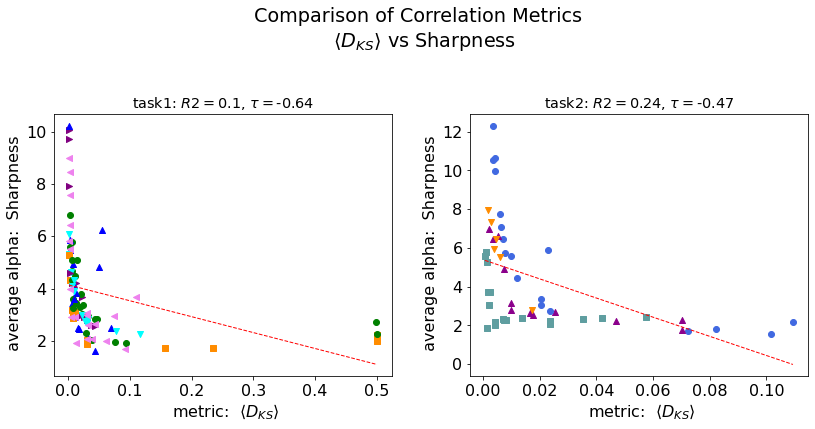

In [9]:
xlab = U.QUALITY_FIT_EQN
ylab = metric_eqn#U.AVG_ALPHA_EQN
title = "Comparison of Correlation Metrics \n "+xlab + " vs " + ylab
    
    
shape=[1,2]
rcParams['figure.figsize'] = 6*shape[1],6*shape[0]
rcParams.update({'font.size': 16})

fig, axes = plt.subplots(shape[0], shape[1])
subplts = axes.flatten()[::-1].tolist()
fig.suptitle(title)
fig.tight_layout(pad=2.0)
rcParams.update({'font.size': 12})


for task in ["task1_v4", "task2_v1"]:
    subplt = subplts.pop()
    these_details = U.read_details(task)
    task_metrics = U.read_task_metrics(task, out_dir)

    x, y = [], []
    for mid, details in these_details.items():
        dW = task_metrics[int(mid)]
        if dW != "EXCEEDED":
            details = details[details['N']> 10]
            details = details[details['M']> 10]
            alpha = details['alpha'].dropna().mean()

            color = U.mid_color(task,mid)
            marker = U.mid_shape(task,mid)
            subplt.scatter(dW, alpha, color=color, marker=marker)
            x.append(dW)
            y.append(alpha)
        
        
    x = np.array(x)
    y = np.array(y)
    p = x.argsort()     
    x = x[p].reshape(-1,1)
    y = y[p].reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    subplt.plot(x, y_pred, color='red', linewidth=1, linestyle="--")

    #Table 4
    R2 = r2_score(y, y_pred)
    tau, p_value = stats.kendalltau(x, y)

    taskname = U.taskname(task)
    subplt.set_title(taskname+r": $R2={:0.2}$, $\tau=${:0.2}".format(R2,tau));
    subplt.set_xlabel(" metric:  "+xlab);
    subplt.set_ylabel(" average alpha:  "+ylab);



#### Comparisons per Model Group xxx

Select the show-output button to see the relation for each model group.  Note that the Kendal-$\tau$ rank correlation metric varies between $0.36$ and $0.91$ for the different model groups. 

Read 96 details dataframes for task1_v4


Read 54 details dataframes for task2_v1


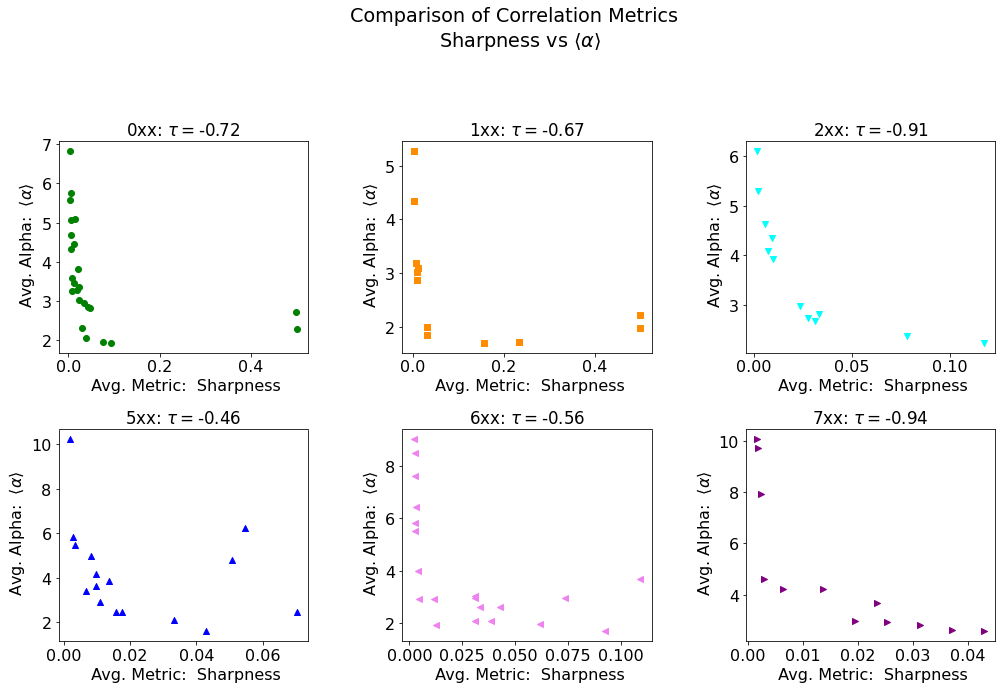

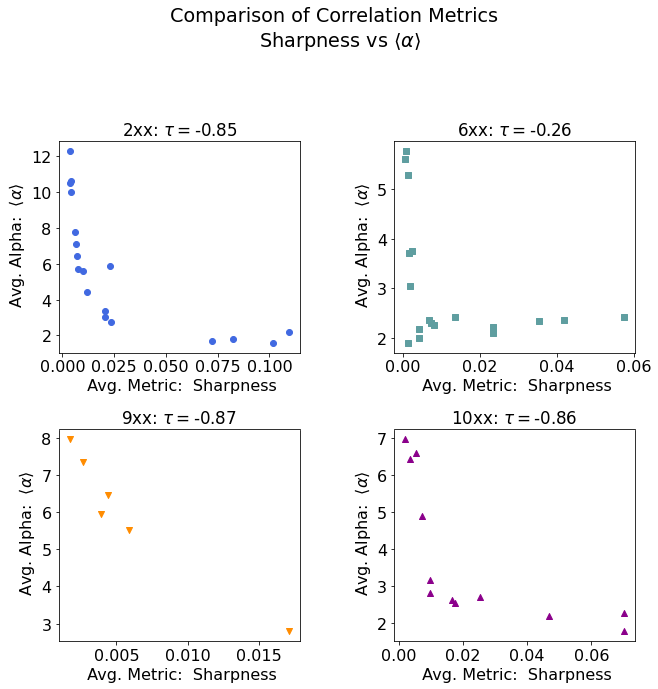

In [10]:
xlab = metric_eqn#U.QUALITY_FIT_EQN 
ylab = U.AVG_ALPHA_EQN
title = "Comparison of Correlation Metrics \n "+xlab + " vs " + ylab

for task, shape in zip(["task1_v4", "task2_v1"], [(2,3), (2,2)]):
    these_details = U.read_details(task)
    task_metrics = U.read_task_metrics(task, out_dir)

    
    rcParams['figure.figsize'] = 5*shape[1],5*shape[0]
    rcParams.update({'font.size': 16})

    fig, axes = plt.subplots(shape[0], shape[1])
    subplts = axes.flatten()[::-1].tolist()
    fig.suptitle(title)
    
    rcParams.update({'font.size': 14})
    fig.tight_layout(pad=3.5)

    
    ktau_s[task]={}
    spear_s[task] = {}
    
    for group_model, values in modelgroup_accuracies[task].items():
        subplt = subplts.pop()
        x, y = [], []
        
        mids = [v[0] for v in values]
        #print("processing modesl {}xx: {}".format(group_model, mids))
        
        for mid in mids:
            details = these_details[str(mid)]
            dW = task_metrics[int(mid)]
            
            if dW !='EXCEEDED':
                details = details[details['N']> 10]
                details = details[details['M']> 10]
                alpha =details['alpha'].dropna().mean()
                color = U.mid_color(task,mid)
                marker = U.mid_shape(task,mid)
                subplt.scatter(dW, alpha, color=color, marker=marker)
                x.append(dW)
                y.append(alpha)
        

        tau, p_value = stats.kendalltau(x, y)
        subplt.set_title(r"{}xx: $\tau=${:0.2}".format(group_model, tau));
        subplt.set_xlabel(" Avg. Metric:  "+xlab);
        subplt.set_ylabel(" Avg. Alpha:  "+ylab);
            